In [1]:
from google.colab import drive
drive.mount('/content/drive')

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

path = '/content/drive/MyDrive/Fakenews/train.csv'
# test_path = '/content/drive/MyDrive/Fakenews/test.csv'

df = pd.read_csv(path)
df.head(5)


Mounted at /content/drive


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [2]:
print(df.shape)
df.isna().sum()

(20800, 5)


id           0
title      558
author    1957
text        39
label        0
dtype: int64

,title,label
0,"Life: After 55 Years Of Research, Jane Goodall...",1
1,Jean Kennedy Smith Remembers Growing Up Kenned...,0
2,"Guardian Opinion Writer: Trump, Bannon Countin...",0
3,"Senate Formally Takes Up Gorsuch Nomination, a...",0
4,Mark Ruffalo Delivers Mobile Solar Trailers to...,1
...,...,...
20237,Kellyanne Conway: Obama’s Russia Sanctions Mea...,0
20238,A Virginia Reader Writes On The Astounding Chu...,1
20239,Voting Suspended At French Consulate in New Yo...,0
20240,SHOCK VIDEO: Hillary Supporters ATTACK Homeles...,1


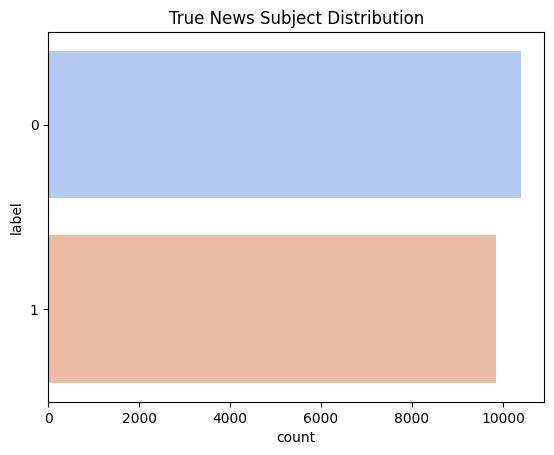

In [3]:
from sklearn.utils import shuffle

df = df[~df['title'].isna()][['title','label']]

# Shuffle
df = shuffle(df).reset_index(drop=True)

display(df)
sns.countplot(y="label", palette="coolwarm", data=df).set_title('True News Subject Distribution')
plt.show()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20242 entries, 0 to 20241
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   20242 non-null  object
 1   label   20242 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 316.4+ KB


In [5]:
df.drop_duplicates(subset=['title'],keep='first',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19803 entries, 0 to 20241
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   19803 non-null  object
 1   label   19803 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 464.1+ KB


In [6]:
train_val_df = df.sample(frac = 0.8)
test_df = df.drop(train_val_df.index)

train_df = train_val_df.sample(frac = 0.875)
val_df = train_val_df.drop(train_df.index)

# Reset Index
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print('trainset size:', train_df.shape)
print('valset size:', val_df.shape)
print('testset size:', test_df.shape)

trainset size: (13862, 2)
valset size: (1980, 2)
testset size: (3961, 2)


In [7]:
from sklearn.utils import resample
def upsample_data(df):
    df_majority = df[df.label == 0]
    df_minority = df[df.label == 1]
    if len(df_majority) >= len(df_minority):
      df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)
      df_upsampled = pd.concat([df_majority, df_minority_upsampled])
      df_upsampled = df_upsampled.sample(frac=1, random_state=42).reset_index(drop=True)
    else:
      df_majority_upsampled = resample(df_majority, replace=True, n_samples=len(df_minority), random_state=42)
      df_upsampled = pd.concat([df_minority, df_majority_upsampled])
      df_upsampled = df_upsampled.sample(frac=1, random_state=42).reset_index(drop=True)
    return df_upsampled

train_df= upsample_data(train_df)
val_df= upsample_data(val_df)

In [8]:
train_df.to_csv('train.tsv', sep='\t', index=False)
val_df.to_csv('val.tsv', sep='\t', index=False)
test_df.to_csv('test.tsv', sep='\t', index=False)

In [9]:
!pip install transformers
import torch
from transformers import BertTokenizer
PRETRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 25.0 MB/s eta 0:00:00


In [10]:
from torch.utils.data import Dataset

class FakeNewsDataset(Dataset):
    def __init__(self, mode, tokenizer):
        assert mode in ['train', 'val', 'test']
        self.mode = mode
        self.df = pd.read_csv(mode + '.tsv', sep='\t').fillna("")
        self.len = len(self.df)
        self.tokenizer = tokenizer  # BERT tokenizer

    def __getitem__(self, idx):
        if self.mode == 'test':
            statement, label = self.df.iloc[idx, :].values
            label_tensor = torch.tensor(label)
        else:
            statement, label = self.df.iloc[idx, :].values
            label_tensor = torch.tensor(label)

        word_pieces = ['[CLS]']
        statement = self.tokenizer.tokenize(statement)
        word_pieces += statement + ['[SEP]']
        len_st = len(word_pieces)

        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        tokens_tensor = torch.tensor(ids)

        segments_tensor = torch.tensor([0] * len_st, dtype=torch.long)
        
        return (tokens_tensor, segments_tensor, label_tensor)
    
    def __len__(self):
        return self.len
    
    
# Initialize Datasets for Transformation
trainset = FakeNewsDataset('train', tokenizer=tokenizer)
valset = FakeNewsDataset('val', tokenizer=tokenizer)
testset = FakeNewsDataset('test', tokenizer=tokenizer)

print('trainset size:' ,trainset.__len__())
print('valset size:',valset.__len__())
print('testset size: ',testset.__len__())

trainset size: 14554
valset size: 2090
testset size:  3961


In [11]:
sample_idx = 0

statement, label = trainset.df.iloc[sample_idx].values

tokens_tensor, segments_tensor, label_tensor = trainset[sample_idx]

tokens = tokenizer.convert_ids_to_tokens(tokens_tensor.tolist())
combined_text = " ".join(tokens)

print(f"""
original_statement: 
{statement}

tokens: 
{tokens}

label: {label}

--------------------

tokens_tensor: 
{tokens_tensor}

segments_tensor: 
{segments_tensor}

label_tensor: 
{label_tensor}

""")


original_statement: 
Débat Primaire de la Droite : les Français pas à l’abri que des sujets de fonds soient accidentellement abordés >> Le Gorafi

tokens: 
['[CLS]', 'de', '##bat', 'prima', '##ire', 'de', 'la', 'dr', '##oit', '##e', ':', 'les', 'francais', 'pas', 'a', 'l', '’', 'ab', '##ri', 'que', 'des', 'su', '##jet', '##s', 'de', 'fond', '##s', 'so', '##ient', 'accident', '##elle', '##ment', 'ab', '##ord', '##es', '>', '>', 'le', 'gora', '##fi', '[SEP]']

label: 1

--------------------

tokens_tensor: 
tensor([  101,  2139, 14479, 21111,  7442,  2139,  2474,  2852, 28100,  2063,
         1024,  4649, 22357, 14674,  1037,  1048,  1521, 11113,  3089, 10861,
         4078, 10514, 15759,  2015,  2139, 13545,  2015,  2061, 11638,  4926,
        14774,  3672, 11113,  8551,  2229,  1028,  1028,  3393, 26967,  8873,
          102])

segments_tensor: 
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])



In [12]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def create_mini_batch(samples):
    tokens_tensors = [s[0] for s in samples]
    segments_tensors = [s[1] for s in samples]

    if samples[0][2] is not None:
        label_ids = torch.stack([s[2] for s in samples])
    else:
        label_ids = None
    
    # Zero Padding
    tokens_tensors = pad_sequence(tokens_tensors, batch_first=True)
    segments_tensors = pad_sequence(segments_tensors, batch_first=True)

    masks_tensors = torch.zeros(tokens_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0, 1)
    
    return tokens_tensors, segments_tensors, masks_tensors, label_ids


BATCH_SIZE = 32
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)
testloader = DataLoader(testset, batch_size=BATCH_SIZE,collate_fn=create_mini_batch)

In [13]:
data = next(iter(trainloader))

tokens_tensors, segments_tensors, masks_tensors, label_ids = data

In [14]:
from transformers import BertForSequenceClassification
from IPython.display import display, clear_output

PRETRAINED_MODEL_NAME = "bert-base-uncased"
NUM_LABELS = 2
# dropout_rate = 0.1
model = BertForSequenceClassification.from_pretrained(
    # PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS, hidden_dropout_prob=dropout_rate)
    PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)

clear_output()

In [15]:
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import time
import torch.optim as optim
from transformers import get_linear_schedule_with_warmup

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
model = model.to(device)

model.train()
# optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
NUM_EPOCHS = 3
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = len(trainloader) * NUM_EPOCHS)

start_time = time.time()
for epoch in range(NUM_EPOCHS):
    train_loss = 0.0
    train_acc = 0.0

    loop = tqdm(trainloader)
    for batch_idx, data in enumerate(loop):
        tokens_tensors, segments_tensors, masks_tensors, labels = [t.to(device) for t in data]

        optimizer.zero_grad()
        
        outputs = model(input_ids=tokens_tensors, 
                        token_type_ids=segments_tensors, 
                        attention_mask=masks_tensors, 
                        labels=labels)
        loss = outputs[0]
        loss.backward()
        optimizer.step()

        logits = outputs[1]
        _, pred = torch.max(logits.data, 1)
        train_acc = accuracy_score(pred.cpu().tolist() , labels.cpu().tolist())

        train_loss += loss.item()

        loop.set_description(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
        loop.set_postfix(acc = train_acc, loss = train_loss)

        scheduler.step()

end_time = time.time()
training_time = end_time - start_time

device: cuda:0


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/455 [00:00<?, ?it/s]

In [16]:
torch.save(model, './best_model.pth')

BERT Model Accuracy :  0.9525372380711942
Precision :  0.9642470205850487
Recall :  0.935856992639327
F1 :  0.9498399146211314
G-mean: 0.9517660755762744
Training time:  353.8987817764282
Inference time:  9.663235425949097
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      2059
           1       0.96      0.94      0.95      1902

    accuracy                           0.95      3961
   macro avg       0.95      0.95      0.95      3961
weighted avg       0.95      0.95      0.95      3961



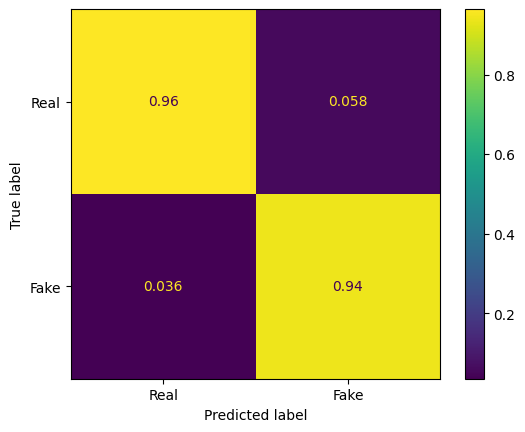

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from imblearn.metrics import geometric_mean_score
true=[]
predictions=[]
start_time = time.time()
with torch.no_grad():
    model.eval()
    for data in testloader:
        if next(model.parameters()).is_cuda:
            data = [t.to(device) for t in data if t is not None]
            
        tokens_tensors, segments_tensors, masks_tensors = data[:3]
        test_outputs = model(input_ids=tokens_tensors, 
                    token_type_ids=segments_tensors, 
                    attention_mask=masks_tensors)

        logits = test_outputs[0]
        _, pred = torch.max(logits.data, 1)

        labels = data[3]
        true.extend(labels.cpu().tolist())
        predictions.extend(pred.cpu().tolist())

end_time = time.time()
inference_time = end_time - start_time
cm = confusion_matrix(true, predictions, labels=[1, 0], normalize='pred')

accuracy = accuracy_score(true, predictions)

g_mean = geometric_mean_score(true, predictions)
print("BERT Model Accuracy : ", accuracy)
print("Precision : ", precision_score(true, predictions))
print("Recall : ", recall_score(true, predictions))
print("F1 : ", f1_score(true, predictions))
print("G-mean:", g_mean)
print("Training time: ", training_time)
print("Inference time: ", inference_time)
print(classification_report(true, predictions))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real','Fake'])
disp.plot()